### Validation of layer profiles of midrange connectivity
➤ Actual synapse densities vs. layer profiles used in the recipe

In [11]:
import numpy as np
import pandas as pd
import yaml
import os
import matplotlib.pyplot as plt
from bluepy import Circuit
from voxcell import RegionMap
from wm_utility.wm_recipe_utility import lookup_population_in_recipe

# Path to the wm-style recipe that has been used to create the connectivity [from SSCXDIS-323]
fn_recipe = "./data/rat_wm_recipe_tr_ll_ul_un_n_m_subtract_adjacents.yaml"

# Circuit config
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_WM'

# Midrange projections name
proj_name = 'intra_SSCX_midrange_wm'

# Load recipe
with open(fn_recipe, "r") as fid:
    recipe = yaml.load(fid, Loader=yaml.SafeLoader)

# Load circuit & get midrange projections
c = Circuit(circuit_config)
fn_proj = c.config['projections'][proj_name]
proj_path = os.path.join(os.path.split(fn_proj)[0], 'feathers')

# Prepare saving
save_path = './figs'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [148]:
# Get all projections
projections = []
src_regions = []
tgt_regions = []
profiles = []
densities = []
proj_files = []
for proj in recipe['projections']:
    src = proj['source']
    src_name = lookup_population_in_recipe(src, recipe)
    for tgt in proj['targets']:
        tgt_name = lookup_population_in_recipe(tgt['population'], recipe)
        projections.append(tgt['projection_name'])
        src_regions.append(src_name)
        tgt_regions.append(tgt_name)
        profiles.append(tgt['target_layer_profiles'][0]['name'])
        densities.append(tgt['density'])
        proj_files.append(os.path.join(proj_path, tgt['projection_name'] + '.feather'))

print(f'{len(projections)} projections found in recipe:')
for p in range(len(projections)):
    print(f'{projections[p]}: {"/".join(src_regions[p])}-{"/".join(tgt_regions[p])} ({profiles[p]})', end='')
    
    # Check if corrsponding projection file exists
    if not os.path.exists(proj_files[p]):
        print(f' ERROR: FILE NOT FOUND')
    else:
        print()


111 projections found in recipe:
SSp-tr_23_to_SSp-ll_ipsi: S1Tr-S1HL (profile_6)
SSp-tr_23_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_6)
SSp-tr_23_to_SSp-un_ipsi: S1Tr-S1DZ (profile_3)
SSp-tr_4_to_SSp-ll_ipsi: S1Tr-S1HL (profile_3)
SSp-tr_4_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_3)
SSp-tr_4_to_SSp-un_ipsi: S1Tr-S1DZ (profile_3)
SSp-tr_5it_to_SSp-ll_ipsi: S1Tr-S1HL (profile_4)
SSp-tr_5it_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_4)
SSp-tr_5it_to_SSp-un_ipsi: S1Tr-S1DZ (profile_1)
SSp-tr_5pt_to_SSp-ll_ipsi: S1Tr-S1HL (profile_4)
SSp-tr_5pt_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_4)
SSp-tr_5pt_to_SSp-un_ipsi: S1Tr-S1DZ (profile_4)
SSp-tr_6_to_SSp-ll_ipsi: S1Tr-S1HL (profile_6)
SSp-tr_6_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_6)
SSp-tr_6_to_SSp-un_ipsi: S1Tr-S1DZ (profile_6)
SSp-ll_23_to_SSp-tr_ipsi: S1HL-S1Tr (profile_3)
SSp-ll_23_to_SSp-ul_ipsi: S1HL-S1FL/S1Sh (profile_3)
SSp-ll_23_to_SSp-un_ipsi: S1HL-S1DZ (profile_3)
SSp-ll_4_to_SSp-tr_ipsi: S1HL-S1Tr (profile_3)
SSp-ll_4_to_SSp-ul_ipsi: S

In [155]:
# Load brain atlas
region_map = RegionMap.load_json(c.atlas.fetch_hierarchy())
atlas_regions = c.atlas.load_data('brain_regions')

rids = list(np.unique(atlas_regions.raw[atlas_regions.raw > 0])) # Region ids
racrs = [region_map.get(rid, 'acronym') for rid in rids] # Region acronyms
layers = list(np.unique([int(racr.split(';')[1][1:]) for racr in racrs]))

regions = np.unique(np.hstack(tgt_regions)) # All target regions
atlas_ids = np.zeros((len(layers), len(regions)), dtype=int) # Atlas ids for given layers/regions
for ridx, reg in enumerate(regions):
    for lidx, lay in enumerate(layers):
        atlas_ids[lidx, ridx] = list(region_map.find(f'{reg};L{lay}', 'acronym'))[0]

# Compute voxel-based depth [depth = height - distance] and rel. depth [rel_depth = (height - distance) / height] values
atlas_height = c.atlas.load_data('height')
atlas_distance = c.atlas.load_data('distance')
vox_depth = atlas_height.raw - atlas_distance.raw
vox_rel_depth = (atlas_height.raw - atlas_distance.raw) / atlas_height.raw
del atlas_height, atlas_distance

print(f'LOADED {len(layers)} layers and {len(regions)} regions from brain atlas')

LOADED 6 layers and 8 regions from brain atlas


In [157]:
# Load synapse property tables (incl. positions) of midrange projections
sel_idx = 4
proj_name = projections[sel_idx]
print(f'PROCESSING {proj_name}...')
syn_table = pd.read_feather(proj_files[sel_idx])

PROCESSING SSp-tr_4_to_SSp-ul_ipsi...


In [162]:
# Rel. depth profiles (voxel-based densities & depth estimates)

## Voxel-based synapse densities
syn_pos = syn_table[['x', 'y', 'z']]
syn_atlas_idx = atlas_regions.positions_to_indices(syn_pos.values)
idx, cnt = np.unique(syn_atlas_idx, axis=0, return_counts=True)
vox_syn_count = np.zeros_like(atlas_regions.raw, dtype=int)
vox_syn_count[idx[:, 0], idx[:, 1], idx[:, 2]] += cnt # Count synapses per voxel => DUPLICATES TO BE TAKEN INTO ACCOUNT!!
vox_syn_density = vox_syn_count / atlas_regions.voxel_volume # (#Syn/um3)

## Depth histogram per region
num_rel_depth_bins = 50
rel_depth_bins = np.linspace(np.nanmin(vox_rel_depth), np.nanmax(vox_rel_depth), num_rel_depth_bins + 1)
rel_depth_bin_centers = np.array([np.mean(rel_depth_bins[i : i + 2]) for i in range(num_rel_depth_bins)])

rel_depth_values = vox_rel_depth[~np.isnan(vox_rel_depth)]
density_values = vox_syn_density[~np.isnan(vox_rel_depth)]
regid_values = atlas_regions.raw[~np.isnan(vox_rel_depth)]

rel_depth_density_hist = np.zeros((num_rel_depth_bins, len(regions)))
for ridx, reg in enumerate(regions):
    for didx in range(num_rel_depth_bins):
        dmin = rel_depth_bins[didx]
        dmax = rel_depth_bins[didx + 1]
        if didx + 1 == num_rel_depth_bins:
            dmax += 1 # So that border values also included in last bin
        dsel = np.logical_and(rel_depth_values >= dmin, rel_depth_values < dmax)
        rsel = np.in1d(regid_values, atlas_ids[:, ridx])
        if np.sum(np.logical_and(dsel, rsel)) > 0:
            rel_depth_density_hist[didx, ridx] = np.mean(density_values[np.logical_and(dsel, rsel)]) # Mean density in a given depth range
        else:
            rel_depth_density_hist[didx, ridx] = 0.0

In [163]:
# Estimate rel. layer depth boundaries (voxel-based)
rel_layer_depth_range = np.zeros((len(layers), len(regions), 2))
for ridx, reg in enumerate(regions):
    for lidx, lay in enumerate(layers):
        dval_tmp = rel_depth_values[regid_values == atlas_ids[lidx, ridx]]
        rel_layer_depth_range[lidx, ridx, :] = [np.min(dval_tmp), np.max(dval_tmp)]

In [164]:
# Extract density profile from recipe
profile_idx = np.where([profile['name'] == profiles[sel_idx] for profile in recipe['layer_profiles']])[0][0]
profile_recipe = recipe['layer_profiles'][profile_idx]['relative_densities']

density_layer_profile = np.zeros(len(layers))
for p_idx, p_dict in enumerate(profile_recipe):
    for lay in p_dict['layers']:
        density_layer_profile[int(lay[1:]) - 1] = densities[sel_idx] * p_dict['value']

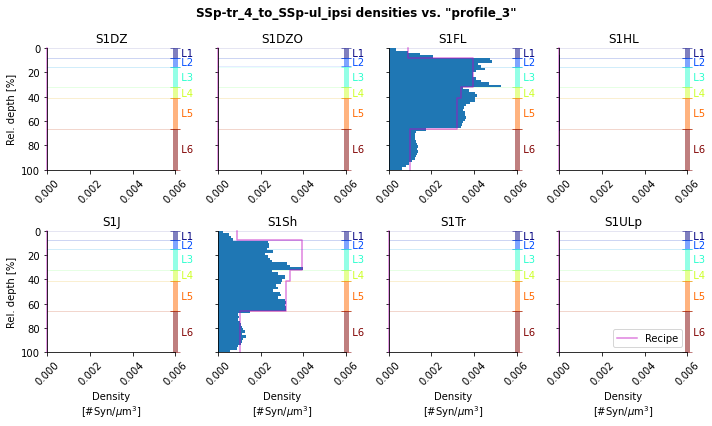

In [175]:
# Plot rel. synapse density profiles (voxel-based)
lcolors = plt.cm.jet(np.linspace(0, 1, len(layers)))
plt.figure(figsize=(10, 6))
plt.gcf().patch.set_facecolor('w')
for ridx, reg in enumerate(regions):
    plt.subplot(2, np.ceil(len(regions) / 2).astype(int), ridx + 1)
    plt.barh(100.0 * rel_depth_bin_centers, rel_depth_density_hist[:, ridx], np.diff(100.0 * rel_depth_bin_centers[:2]))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlim([0, 0.006])
    plt.ylim([100.0 * rel_depth_bins[0], 100.0 * rel_depth_bins[-1]])
    plt.gca().invert_yaxis()
    plt.xticks(rotation=45)
    plt.title(reg)
    if ridx >= np.ceil(len(regions) / 2).astype(int):
        plt.xlabel('Density\n[#Syn/$\mu$m$^3$]')
    ## Plot layer boundaries
    for lidx, lay in enumerate(layers):
        plt.plot(np.ones(2) * max(plt.xlim()), 100.0 * rel_layer_depth_range[lidx, ridx, :], '-_', color=lcolors[lidx, :], linewidth=5, alpha=0.5, solid_capstyle='butt', markersize=10, clip_on=False)
        plt.text(max(plt.xlim()), 100.0 * np.mean(rel_layer_depth_range[lidx, ridx, :]), '  L{}'.format(lay), color=lcolors[lidx, :], ha='left', va='center')
        plt.plot(plt.xlim(), np.ones(2) * 100.0 * rel_layer_depth_range[lidx, ridx, 0], '-', color=lcolors[lidx, :], linewidth=1, alpha=0.1, zorder=0)
        plt.plot(plt.xlim(), np.ones(2) * 100.0 * rel_layer_depth_range[lidx, ridx, 1], '-', color=lcolors[lidx, :], linewidth=1, alpha=0.1, zorder=0)
    if np.mod(ridx, np.ceil(len(regions) / 2).astype(int)) == 0:
        plt.ylabel('Rel. depth [%]')
    else:
        plt.gca().set_yticklabels([])

    # Plot intended densities from recipe
    if reg in tgt_regions[sel_idx]:
        pscale = 1.0
    else:
        pscale = 0.0
    plt.step(pscale * np.repeat(density_layer_profile, 2), 100.0 * rel_layer_depth_range[:, ridx, :].flatten(), 'm', where='post', linewidth=1.5, alpha=0.5, clip_on=False, label='Recipe')
plt.legend(loc='lower right')
plt.suptitle(f'{projections[sel_idx]} densities vs. "{profiles[sel_idx]}"', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'{projections[sel_idx]}_profiles.png'), dpi=300)
plt.show()